# Random Forest

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay



Load data and do some clean-up

In [25]:
df = pd.read_csv("codon_usage.csv")

print(df.head())
print(df.info())

# Convert problematic columns (UUU, UUC) to numeric, coerce errors to NaN
df['UUU'] = pd.to_numeric(df['UUU'], errors='coerce')
df['UUC'] = pd.to_numeric(df['UUC'], errors='coerce')


# Remove irrelevant columns
df_ml = df.drop(columns=['SpeciesID', 'SpeciesName', 'DNAtype'], errors='ignore')

# Drop rows with missing values
df_ml = df_ml.dropna()

  Kingdom  DNAtype  SpeciesID  Ncodons  \
0     vrl        0     100217     1995   
1     vrl        0     100220     1474   
2     vrl        0     100755     4862   
3     vrl        0     100880     1915   
4     vrl        0     100887    22831   

                               SpeciesName      UUU      UUC      UUA  \
0  Epizootic haematopoietic necrosis virus  0.01654  0.01203  0.00050   
1                         Bohle iridovirus  0.02714  0.01357  0.00068   
2             Sweet potato leaf curl virus  0.01974   0.0218  0.01357   
3             Northern cereal mosaic virus  0.01775  0.02245  0.01619   
4           Soil-borne cereal mosaic virus  0.02816  0.01371  0.00767   

       UUG      CUU  ...      CGG      AGA      AGG      GAU      GAC  \
0  0.00351  0.01203  ...  0.00451  0.01303  0.03559  0.01003  0.04612   
1  0.00678  0.00407  ...  0.00136  0.01696  0.03596  0.01221  0.04545   
2  0.01543  0.00782  ...  0.00596  0.01974  0.02489  0.03126  0.02036   
3  0.00992  0.01

/tmp/ipykernel_554670/2698226863.py:1: DtypeWarning: Columns (5,6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("codon_usage.csv")


# Plot Average Codon usage by Kingdom

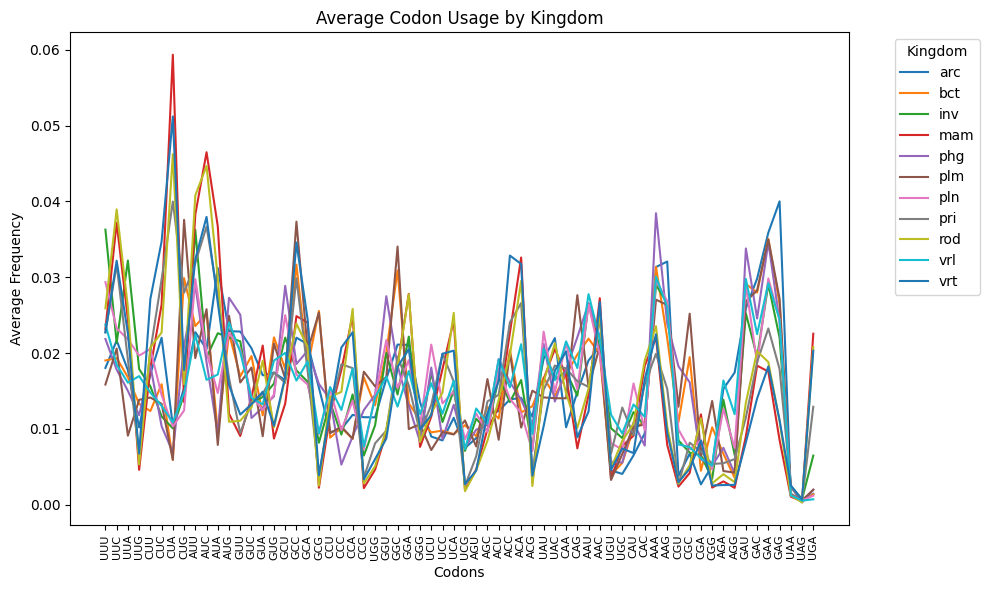

In [19]:
# Group by Kingdom and calculate mean codon usage across numeric columns
grouped_df = df.groupby('Kingdom').mean(numeric_only=True)

# Remove non-codon columns (like 'DNAtype')
grouped_df = grouped_df.drop(columns=['DNAtype', 'SpeciesID', 'Ncodons'], errors='ignore')

# Plot the mean codon usage by Kingdom
fig, ax = plt.subplots(figsize=(10, 6))  # Adjust figsize for better visibility
grouped_df.T.plot(ax=ax, legend=True)
ax.set_title('Average Codon Usage by Kingdom')
ax.set_xlabel('Codons')
ax.set_ylabel('Average Frequency')

# Display all x-axis labels
ax.set_xticks(range(len(grouped_df.columns)))
ax.set_xticklabels(grouped_df.columns, rotation=90, fontsize=8)

# Move legend outside the plot
ax.legend(title='Kingdom', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

# Plot Number of Entries per Kingdom
1. **arc (Archaea)** – Single-celled microorganisms without a nucleus, often found in extreme environments.
2. **bct (Bacteria)** – Single-celled prokaryotic organisms, widely distributed in various environments.
3. **inv (Invertebrates)** – Animals without a vertebral column, including insects, mollusks, and crustaceans.
4. **mam (Mammals)** – Warm-blooded vertebrates with hair/fur and mammary glands.
5. **phg (Phages)** – Viruses that infect bacteria (bacteriophages).
6. **plm (Plasmodium)** – Parasitic protozoans, including malaria-causing species.
7. **pln (Plants)** – Multicellular photosynthetic organisms.
8. **pri (Primates)** – An order of mammals that includes humans, monkeys, and apes.
9. **rod (Rodents)** – A subgroup of mammals characterized by continuously growing incisors.
10. **vrl (Viruses)** – Infectious agents that replicate inside host cells.
11. **vrt (Vertebrates)** – Animals with a backbone, including mammals, birds, reptiles, amphibians, and fish.

plm contains only a small amount of entries (18), while the others are in the hundreds or thousands.

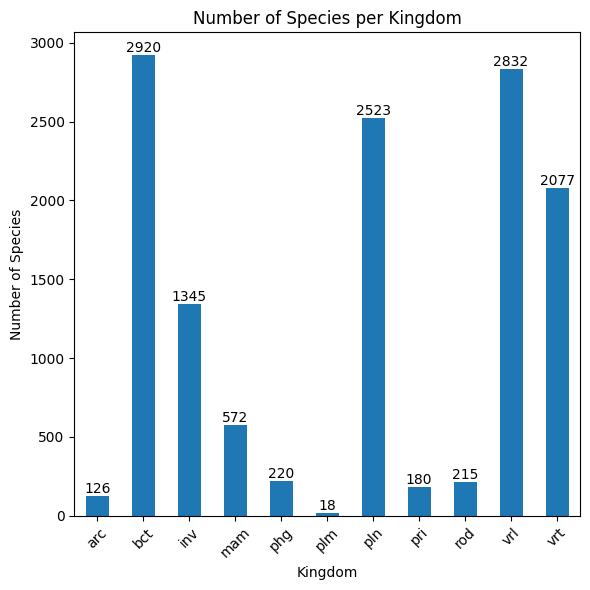

In [30]:
# Count the number of occurrences per Kingdom
kingdom_counts = df['Kingdom'].value_counts().sort_index()

# Plot the counts as a bar plot
fig, ax = plt.subplots(figsize=(6, 6))
kingdom_counts.plot(kind='bar', ax=ax)
#print(kingdom_counts)

# Enhance readability
ax.set_title('Number of Species per Kingdom')
ax.set_xlabel('Kingdom')
ax.set_ylabel('Number of Species')
ax.bar_label(ax.containers[0])  # Display counts on top of bars (matplotlib >= 3.4)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Train Class Distribution:
 1     0.224141
9     0.217329
6     0.193629
10    0.159470
2     0.103243
3     0.043945
4     0.016887
8     0.016504
7     0.013817
0     0.009691
5     0.001343
Name: proportion, dtype: float64
Test Class Distribution:
 1     0.224098
9     0.217575
6     0.193784
10    0.159248
2     0.103223
3     0.043745
4     0.016884
8     0.016500
7     0.013814
0     0.009593
5     0.001535
Name: proportion, dtype: float64
Class Weights: {np.int64(0): np.float64(9.38073807380738), np.int64(1): np.float64(0.40558841843088417), np.int64(2): np.float64(0.8805339641770868), np.int64(3): np.float64(2.068678046843986), np.int64(4): np.float64(5.383264462809917), np.int64(5): np.float64(67.67532467532467), np.int64(6): np.float64(0.46950175691503737), np.int64(7): np.float64(6.579545454545454), np.int64(8): np.float64(5.50845665961945), np.int64(9): np.float64(0.41830222757375074), np.int64(10): np.float64(0.5700689202494257)}
Accuracy: 0.9006139677666922
              p

/home/alex/Masters/CO2_ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alex/Masters/CO2_ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alex/Masters/CO2_ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

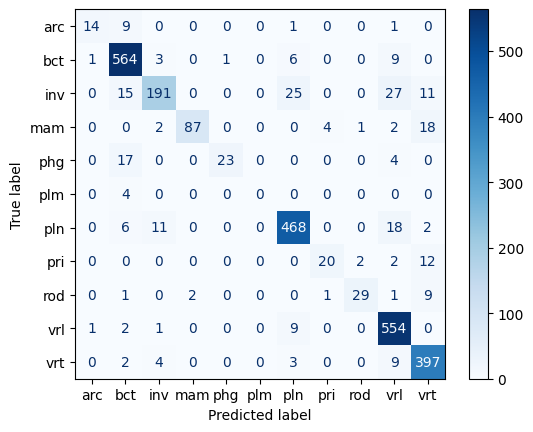

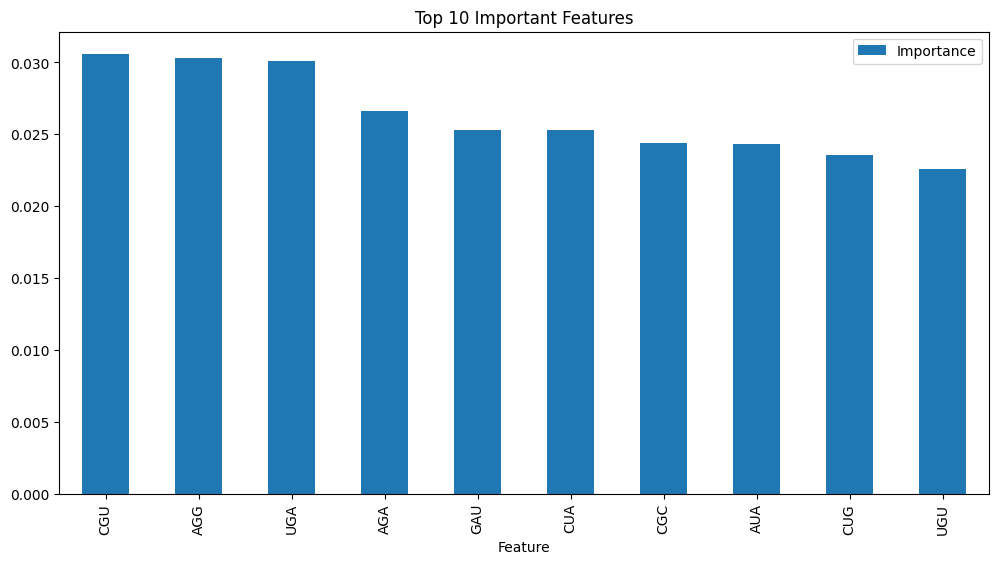

In [26]:
# 5. Separate features and target
X = df_ml.drop(columns=['Kingdom'])
y = df_ml['Kingdom']

# 6. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 7. Encode target labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# 8. Stratified Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_encoded
)

# Check class distribution after split
train_distribution = pd.Series(y_train).value_counts(normalize=True)
test_distribution = pd.Series(y_test).value_counts(normalize=True)
print("Train Class Distribution:\n", train_distribution)
print("Test Class Distribution:\n", test_distribution)

# 9. Compute Class Weights
class_weights = dict(
    zip(
        np.unique(y_train),
        compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
    )
)
print("Class Weights:", class_weights)

# 10. Train Random Forest Classifier with Class Weights
clf = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
clf.fit(X_train, y_train)

# 11. Evaluate the Model
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 12. Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    display_labels=label_encoder.classes_,
    cmap='Blues'
)
plt.show()

# 13. Plot Feature Importance (Optional)
importances = clf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot Top 10 Important Features
feature_importance_df.head(10).plot(kind='bar', x='Feature', y='Importance', figsize=(12, 6))
plt.title('Top 10 Important Features')
plt.show()


Accuracy: 0.9033000767459708
              precision    recall  f1-score   support

         arc       0.88      0.60      0.71        25
         bct       0.91      0.97      0.94       584
         inv       0.94      0.69      0.80       269
         mam       0.95      0.76      0.84       114
         phg       0.95      0.48      0.64        44
         plm       0.00      0.00      0.00         4
         pln       0.91      0.94      0.92       505
         pri       0.88      0.58      0.70        36
         rod       0.93      0.63      0.75        43
         vrl       0.89      0.99      0.93       567
         vrt       0.89      0.96      0.92       415

    accuracy                           0.90      2606
   macro avg       0.83      0.69      0.74      2606
weighted avg       0.90      0.90      0.90      2606



/home/alex/Masters/CO2_ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alex/Masters/CO2_ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alex/Masters/CO2_ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

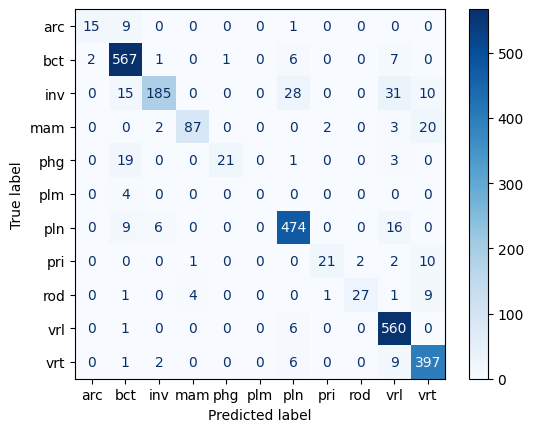

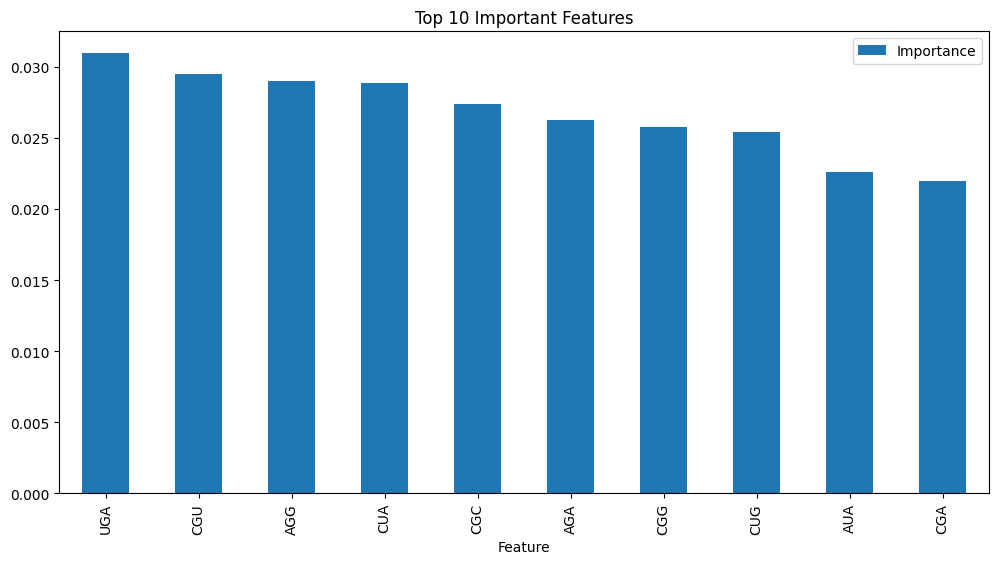

In [27]:
# 10. Train Random Forest Classifier with Class Weights

manual_weights = {
    0: 9.38,  # arc
    1: 0.4,   # bct
    2: 0.88,  # inv
    3: 2.06,  # mam
    4: 5.38,  # phg
    5: 100,   # plm (increase weight manually)
    6: 0.47,  # pln
    7: 6.57,  # pri
    8: 5.5,   # rod
    9: 0.42,  # vrl
    10: 0.57  # vrt
}

clf = RandomForestClassifier(n_estimators=200, random_state=42, class_weight=manual_weights)
clf.fit(X_train, y_train)

# 11. Evaluate the Model
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# 12. Plot Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    clf,
    X_test,
    y_test,
    display_labels=label_encoder.classes_,
    cmap='Blues'
)
plt.show()

# 13. Plot Feature Importance (Optional)
importances = clf.feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot Top 10 Important Features
feature_importance_df.head(10).plot(kind='bar', x='Feature', y='Importance', figsize=(12, 6))
plt.title('Top 10 Important Features')
plt.show()

# Hyperparameter Optimization

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best Parameters: {'class_weight': 'balanced', 'max_depth': 30, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 300}
Best Score: 0.8996412863045263
Accuracy: 0.90752110514198
              precision    recall  f1-score   support

         arc       0.83      0.60      0.70        25
         bct       0.92      0.97      0.94       584
         inv       0.91      0.73      0.81       269
         mam       0.96      0.77      0.85       114
         phg       0.96      0.61      0.75        44
         plm       0.00      0.00      0.00         4
         pln       0.91      0.93      0.92       505
         pri       0.82      0.64      0.72        36
         rod       0.85      0.67      0.75        43
         vrl       0.89      0.98      0.93       567
         vrt       0.91      0.95      0.93       415

    accuracy                           0.91      2606
   macro avg       0.82      0.71      0.76  

/home/alex/Masters/CO2_ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alex/Masters/CO2_ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/alex/Masters/CO2_ML/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is",

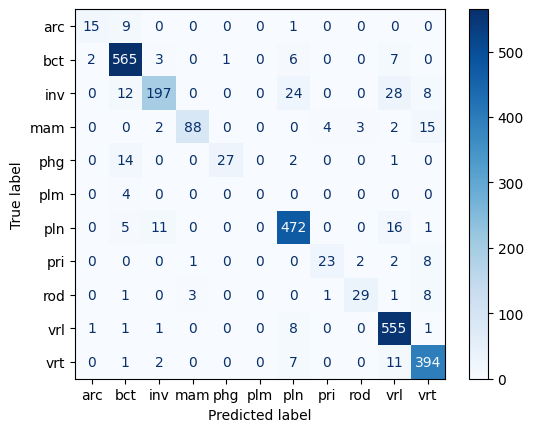

In [28]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced']
}

# Initialize the model
clf = RandomForestClassifier(random_state=42)

# Perform GridSearchCV
grid_search = GridSearchCV(
    estimator=clf,
    param_grid=param_grid,
    cv=5,
    scoring='f1_weighted',
    verbose=2,
    n_jobs=-1
)

# Fit the model
grid_search.fit(X_train, y_train)

# Best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Use the best model
best_clf = grid_search.best_estimator_

# Evaluate the tuned model
y_pred = best_clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
ConfusionMatrixDisplay.from_estimator(
    best_clf, X_test, y_test, display_labels=label_encoder.classes_, cmap='Blues'
)
plt.show()


Best Parameters:
{'class_weight': 'balanced',
 'max_depth': 30,
 'min_samples_leaf': 2,
 'min_samples_split': 5,
 'n_estimators': 300}
